In [5]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


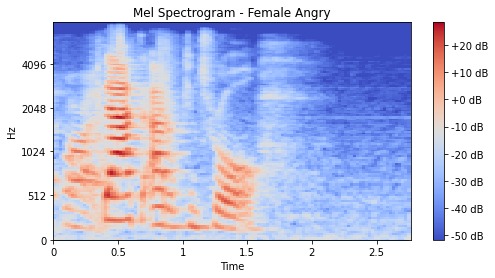

In [6]:
x, sr = librosa.load('/content/drive/MyDrive/iemowav/anger/Ses01F_impro01_F012.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Female Angry')
plt.savefig('Waveplot_FemaleAngry.png')
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Angry')
plt.savefig('MelSpec_FemaleAngry.png')
plt.colorbar(format='%+2.0f dB')

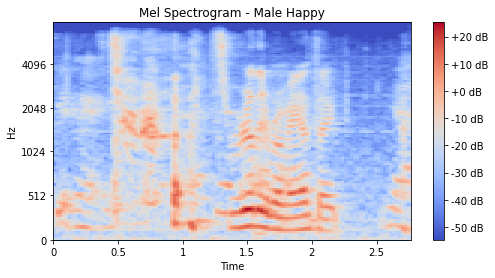

In [13]:
x, sr = librosa.load('/content/drive/MyDrive/iemowav/happiness/Ses01F_impro03_M007.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Happy')
plt.savefig('Waveplot_MaleHappy.png')
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Happy')
plt.savefig('MelSpec_MaleHappy.png')
plt.colorbar(format='%+2.0f dB')

In [14]:
audio = "/content/drive/MyDrive/iemowav/"
emot_folders = os.listdir(audio)
emot_folders.sort() 
emot_folders

['anger', 'happiness', 'neutral', 'sadness']

In [16]:
emotion = []
gender = []
file_path = []
for i in emot_folders:
    filename = os.listdir(audio + i)
    for f in filename:
        if (i == "neutral"):
            emotion.append(1)
        elif (i == "anger"):
            emotion.append(4)
        elif (i == "sadness"):
            emotion.append(3)
        elif (i == "happiness"):
            emotion.append(2)
        if (f[5] == 'F'):
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'happy', 3:'sad', 4:'angry'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,],axis=1)
audio_df.columns = ['gender','emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,path
0,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
1,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
2,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
3,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
4,male,angry,/content/drive/MyDrive/iemowav/anger/Ses01M_sc...
...,...,...,...
4348,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4349,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4350,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...
4351,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses01F_...


In [17]:
pd.set_option('display.max_colwidth', -1)
audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,gender,emotion,path
985,male,angry,/content/drive/MyDrive/iemowav/anger/Ses05M_script01_1_M025.wav
311,female,angry,/content/drive/MyDrive/iemowav/anger/Ses03F_script01_2_M018.wav
3546,male,sad,/content/drive/MyDrive/iemowav/sadness/Ses02M_impro02_M008.wav
3717,female,sad,/content/drive/MyDrive/iemowav/sadness/Ses03F_impro06_F001.wav
1262,male,happy,/content/drive/MyDrive/iemowav/happiness/Ses02M_impro07_F014.wav
647,female,angry,/content/drive/MyDrive/iemowav/anger/Ses04F_impro05_F005.wav
3220,female,neutral,/content/drive/MyDrive/iemowav/neutral/Ses02F_impro06_M006.wav
3338,male,sad,/content/drive/MyDrive/iemowav/sadness/Ses01M_script01_3_F026.wav
3030,female,neutral,/content/drive/MyDrive/iemowav/neutral/Ses01F_script02_2_M047.wav
2110,female,neutral,/content/drive/MyDrive/iemowav/neutral/Ses04F_impro07_M061.wav


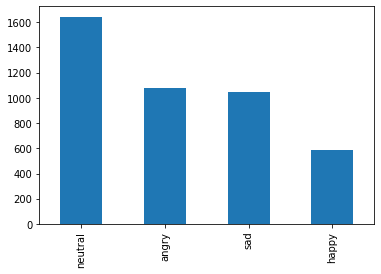

In [18]:
audio_df.emotion.value_counts().plot(kind='bar')

In [19]:
df = pd.DataFrame(columns=['mel_spectrogram'])
for index, path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfcc = np.mean(mfcc,axis=0)
    df.loc[index] = [log_spectrogram]
print(len(df))
df.head()

4353


,mel_spectrogram
0,"[-18.332981, -14.116266, -9.657612, -8.202416, -8.242163, -8.442232, -8.651087, -8.405212, -7.5707107, -7.6870475, -7.7138233, -7.8949394, -8.831333, -11.187662, -13.600159, -15.619257, -17.085653, -18.880491, -20.218126, -22.07987, -22.384058, -21.67692, -20.24763, -18.947168, -18.04995, -17.035894, -17.208607, -17.767954, -17.88133, -16.759119, -14.425985, -12.899227, -13.11994, -14.260677, -15.398872, -15.126982, -13.545614, -11.924828, -10.799414, -9.603018, -10.101297, -9.928793, -10.268061, -10.856106, -11.6273575, -11.760138, -10.750629, -9.964888, -10.196068, -10.709721, -10.49684, -10.816572, -12.301233, -13.873968, -15.04574, -15.675514, -16.495611, -19.194328, -21.57268, -22.522787, -22.363092, -23.569689, -22.347273, -18.863659, -16.029745, -14.323328, -13.597349, -15.696121, -19.238525, -21.161674, -22.747448, -21.138237, -16.107962, -16.543201, -21.14439, -20.603308, -21.172897, -21.768204, -20.969507, -20.176842, -18.89821, -19.593697, -20.386333, -18.855545, -17.17432, -17.514137, -16.06335, -14.240259, -14.760239, -18.001873, -19.652758, -19.898666, -20.996714, -21.245182, -17.957045, -15.975721, -17.96451, -19.48782, -15.180754, -13.448685, ...]"
1,"[-4.934965, -5.456928, -5.0069275, -0.5049695, 1.7210346, 2.5051267, 2.6464548, 3.0630698, 3.231828, -0.25210878, -4.0836296, -5.362368, -6.2634993, -7.4594393, -9.412441, -11.260394, -12.375166, -12.29868, -10.0356245, -9.961284, -11.108835, -9.983057, -8.3523, -8.4807415, -8.749722, -9.220477, -11.002271, -14.106523, -15.893524, -16.408728, -14.926964, -12.162096, -7.3145084, -5.0323143, -4.878666, -4.6190915, -3.1097186, -3.6608553, -4.5365534, -2.9291024, -2.9236665, -5.874891, -6.37327, -6.7887607, -9.068195, -12.117433, -13.386827, -13.640082, -14.38805, -15.544528, -16.517462, -16.071053, -14.890705, -14.382839, -14.415446, -12.856017, -12.167698, -11.623826, -10.930541, -11.472387, -13.169728, -14.5838995, -14.765272, -15.228415, -15.22003, -15.566532, -16.4863, -17.37006, -17.785336, -16.626177, -15.544339, -14.644134, -14.475557, -14.116957, -13.828161, -13.909867, -13.071271, -12.623181, -13.163194, -14.4170475, -16.021595, -16.268137, -17.586525, -18.264734, -18.766123, -18.571026, -18.526474, -18.253176, -17.289808, -16.16665, -16.413477, -16.813255, -16.944624, -17.235584, -18.017286, -20.610836, -22.493248, -22.351082, -21.308905, -19.72217, ...]"
2,"[-36.93271, -36.12232, -36.204025, -36.663876, -37.069653, -37.198677, -36.898403, -36.55384, -36.222607, -36.78746, -36.94582, -37.101418, -36.45278, -36.515217, -36.61675, -36.610188, -36.656876, -36.229877, -36.51826, -35.915073, -36.030777, -36.22323, -36.09559, -36.4875, -36.594864, -35.855583, -35.6211, -36.623253, -36.647354, -36.549683, -36.747986, -36.32416, -36.370193, -35.980923, -36.39997, -36.540237, -36.83709, -36.201298, -36.124344, -36.0679, -36.2585, -36.51574, -36.11842, -36.283985, -36.672974, -36.25431, -36.087837, -36.397106, -36.280087, -36.599632, -36.897068, -37.03356, -36.60404, -36.173916, -36.311768, -36.562603, -37.16677, -36.589123, -36.54752, -26.130568, -20.902882, -17.186747, -13.437074, -15.313151, -15.815891, -14.951625, -14.245847, -14.553124, -17.235125, -20.052795, -21.730314, -22.926365, -22.051737, -21.203888, -19.68295, -19.674479, -21.333511, -23.041708, -24.262465, -25.843477, -26.186338, -26.78261, -27.078394, -26.743128, -25.925304, -23.213623, -20.585197, -17.340263, -14.873641, -13.255693, -12.089643, -9.950153, -8.895758, -7.79335, -5.3306456, -3.8355474, -3.9930468, -3.751917, -3.657069, -4.480909, ...]"
3,"[-32.54228, -32.292522, -33.749, -34.367847, -34.422535, -34.70476, -34.956757, -34.26454, -34.125347, -34.597343, -34.698162, -34.652, -34.402115, -34.387455, -34.609814, -32.90271, -34.15978, -34.564404, -31.766281, -30.78064, -31.174055, -32.073547, -32.87564, -32.836952, -32.267, -31.877659, -32.22514, -31.561699, -32.187767, -33.488518, -34.173927, -34.155975, -34.433193, -34.51933, -34.47402, -34.80535, -33.997387, -32.68619, -

In [33]:
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.drop(columns='path',inplace=True)
df_combined.head()

,gender,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,male,angry,-18.332981,-14.116266,-9.657612,-8.202416,-8.242163,-8.442232,-8.651087,-8.405212,-7.570711,-7.687047,-7.713823,-7.894939,-8.831333,-11.187662,-13.600159,-15.619257,-17.085653,-18.880491,-20.218126,-22.079870,-22.384058,-21.676920,-20.247629,-18.947168,-18.049950,-17.035894,-17.208607,-17.767954,-17.881330,-16.759119,-14.425985,-12.899227,-13.119940,-14.260677,-15.398872,-15.126982,-13.545614,-11.924828,...,-14.359730,-17.883867,-22.461926,-25.089958,-27.302914,-27.120487,-26.364311,-27.416544,-28.675428,-27.360905,-26.462673,-26.668005,-27.847065,-29.066105,-29.346523,-29.824013,-30.171574,-29.731756,-29.666700,-29.300705,-30.406822,-31.140825,-31.705196,-32.407166,-33.515011,-34.460335,-34.710918,-34.928539,-34.557373,-33.531338,-32.985901,-31.212469,-28.327398,-26.216602,-25.716991,-26.484827,-27.247623,-29.651583,-28.829081,-28.796093
1,male,angry,-4.934965,-5.456928,-5.006927,-0.504969,1.721035,2.505127,2.646455,3.063070,3.231828,-0.252109,-4.083630,-5.362368,-6.263499,-7.459439,-9.412441,-11.260394,-12.375166,-12.298680,-10.035625,-9.961284,-11.108835,-9.983057,-8.352300,-8.480742,-8.749722,-9.220477,-11.002271,-14.106523,-15.893524,-16.408728,-14.926964,-12.162096,-7.314508,-5.032314,-4.878666,-4.619092,-3.109719,-3.660855,...,-34.101620,-33.948261,-34.533806,-34.885365,-34.754196,-34.672817,-34.080772,-33.031158,-31.591436,-30.503679,-29.969143,-29.326937,-28.705170,-28.325289,-28.634695,-29.159534,-28.844767,-28.534006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,angry,-36.932709,-36.122318,-36.204025,-36.663876,-37.069653,-37.198677,-36.898403,-36.553841,-36.222607,-36.787460,-36.945820,-37.101418,-36.452782,-36.515217,-36.616749,-36.610188,-36.656876,-36.229877,-36.518261,-35.915073,-36.030777,-36.223228,-36.095589,-36.487499,-36.594864,-35.855583,-35.621101,-36.623253,-36.647354,-36.549683,-36.747986,-36.324162,-36.370193,-35.980923,-36.399971,-36.540237,-36.837090,-36.201298,...,-15.680845,-17.600731,-20.198812,-21.778503,-23.300793,-24.692970,-25.893162,-26.382799,-27.291536,-29.008688,-29.031757,-26.446346,-19.567053,-13.705808,-11.162007,-10.957765,-11.493161,-12.464386,-14.416993,-14.887627,-16.075041,-18.736200,-20.574219,-22.497458,-23.432848,-25.202311,-26.615078,-26.306440,-25.231726,-24.211134,-20.108532,-16.558043,-15.457288,-15.386409,-15.071822,-14.218746,-15.902325,-19.112951,-21.097776,-21.135933
3,male,angry,-32.542278,-32.292522,-33.749001,-34.367847,-34.422535,-34.704762,-34.956757,-34.264542,-34.125347,-34.597343,-34.698162,-34.652000,-34.402115,-34.387455,-34.609814,-32.902710,-34.159779,-34.564404,-31.766281,-30.780640,-31.174055,-32.073547,-32.875641,-32.836952,-32.266998,-31.877659,-32.225140,-31.561699,-32.187767,-33.488518,-34.173927,-34.155975,-34.433193,-34.519329,-34.474018,-34.805351,-33.997387,-32.686192,...,-11.090864,-7.959053,-6.938515,-7.317580,-7.648142,-7.005384,-5.476584,-5.058643,-6.083617,-8.076483,-8.977110,-9.030769,-10.047605,-10.926315,-10.038068,-6.456643,-6.734207,-11.920892,-15.717731,-15.043759,-13.460938,-10.192986,-8.797873,-10.425640,-11.092610,-9.641565,-6.947948,-3.799475,-0.460520,0.944360,0.324266,-0.868986,-3.569535,-6.583885,-9.690835,-11.623006,-9.904118,-5.023348,-0.719579,5.488477
4,male,angry,-24.129431,-23.546932,-23.511160,-23.548304,-23.611528,-23.786627,-24.272623,-24.726603,-25.538305,-24.889400,-23.572332,-22.989904,-23.498262,-23.279007,-23.897373,-23.661999,-22.929302,-14.115327,-7.214966,-6.218278,-6.275562,-4.608382,-4.144124,-1.901392,0.055593,-3.218678,-8.281434,-10.156795,-11.265947,-11.908337,-

In [42]:
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined.head()

,gender,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,male,sad,-39.959969,-38.740223,-38.739880,-38.266644,-37.351555,-38.314060,-38.743023,-36.025524,-32.523304,-32.085594,-31.922546,-32.280651,-33.851822,-36.676037,-37.367477,-37.353859,-36.828979,-33.102940,-31.676804,-32.660892,-32.921928,-33.563820,-33.277225,-33.326450,-33.932335,-34.221535,-34.579655,-33.998978,-34.033859,-33.793659,-33.540558,-33.651669,-34.505188,-35.622044,-36.403011,-36.359905,-37.431210,-37.177448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,female,sad,-41.710899,-39.656921,-37.398495,-34.225254,-32.666477,-31.790880,-31.391216,-32.299644,-33.242855,-34.064869,-35.699642,-37.260006,-38.684811,-39.378807,-40.545277,-41.271450,-40.877304,-40.311611,-41.746498,-43.164040,-44.426891,-45.649216,-46.303909,-47.645000,-47.179695,-46.825066,-47.322617,-47.191666,-47.434559,-47.102566,-46.530018,-45.938087,-43.119381,-40.622131,-39.440327,-39.730774,-39.058533,-38.099152,...,-49.272095,-49.663551,-49.647518,-48.994003,-49.109245,-49.293255,-48.873215,-49.273476,-49.610786,-49.223038,-49.295376,-48.687046,-48.441563,-48.719833,-48.947338,-49.145966,-49.304573,-49.907337,-49.212681,-49.773174,-49.582176,-48.933613,-49.231899,-49.712761,-49.716248,-49.403996,-49.308117,-49.237701,-49.031891,-49.122753,-49.975113,-49.857914,-49.333900,-49.262001,-49.514778,-49.480068,-49.733051,-49.938789,-49.227810,-49.859203
2,male,neutral,-25.344412,-25.693274,-27.603081,-28.367981,-29.369101,-29.811758,-31.538645,-32.816837,-33.544384,-33.742966,-33.051010,-32.102337,-32.256130,-32.181583,-31.736937,-30.567703,-27.655695,-24.735170,-23.082066,-22.866909,-23.072996,-24.095299,-24.878115,-25.954905,-27.005077,-27.943970,-28.668655,-29.234362,-28.616627,-28.054785,-27.298214,-27.158628,-28.439022,-32.215244,-32.782902,-28.645752,-27.618002,-28.532352,...,-28.942524,-29.836468,-30.241905,-31.007357,-31.859671,-32.136982,-32.438454,-32.726303,-32.088879,-32.340027,-31.157331,-29.522087,-28.393524,-27.423979,-25.448011,-24.891249,-27.326839,-30.560665,-29.197937,-26.924095,-25.608540,-25.398195,-25.167250,-24.586296,-24.287668,-24.518703,-24.264816,-23.232683,-21.622650,-20.467184,-19.824068,-20.043976,-20.112459,-20.655832,-21.104418,-21.866169,-23.465353,-24.355410,-26.045727,-25.913017
3,female,neutral,-47.664230,-42.886368,-39.308250,-36.390160,-33.928535,-31.397900,-30.163134,-29.423609,-28.902451,-28.332947,-28.143763,-28.192467,-28.596226,-29.086094,-29.519009,-30.485483,-30.854874,-31.808586,-34.709740,-36.989250,-39.043808,-40.813263,-40.628494,-38.286308,-37.730972,-36.567017,-35.238670,-34.113670,-33.250801,-33.035728,-32.749908,-33.829582,-35.110229,-36.410103,-36.711990,-35.881523,-35.480598,-36.480469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,female,angry,-12.374880,-14.238123,-18.932713,-18.795202,-19.131792,-18.875090,-18.301361,-15.869761,-15.075572,-16.201918,-15.016857,-13.789640,-12.634296,-9.978091,-6.304805,-5.059391,-6.693750,-8.233123,-10.774239,-13.002876,-13.849768,-14.180884,-14.406399,-14.670672,-15.474847,-16.634472,-17.336895,-17.823387,-18.267071,-19.086674,-20.439993,-20.286959,-19.827061

In [43]:
train,test = train_test_split(df_combined, test_size=0.2, random_state=0, stratify=df_combined[['emotion','gender']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(3482, 258)
(871, 258)


In [44]:
from sklearn import tree


print(X_train.shape)
print(X_test.shape)
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

(3482, 258)
(871, 258)


0.269804822043628

In [45]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.4305396096440873

In [46]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
print(lb.classes_)
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
['angry' 'happy' 'neutral' 'sad']


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(3482, 258, 1)

In [47]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(layers.Conv1D(64, kernel_size=(8), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, kernel_size=(5),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(1)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 251, 64)           576       
_________________________________________________________________
batch_normalization_12 (Batc (None, 251, 64)           256       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 244, 128)          65664     
_________________________________________________________________
batch_normalization_13 (Batc (None, 244, 128)          512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 40, 128)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 33, 128)          

In [48]:
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history = model.fit(X_train, y_train,batch_size=32, epochs=64, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/64
109/109 [==============================] - 2s 9ms/step - loss: 2.5321 - accuracy: 0.3697 - val_loss: 2.3972 - val_accuracy: 0.2480

Epoch 00001: val_accuracy improved from -inf to 0.24799, saving model to best_initial_model.hdf5
Epoch 2/64
109/109 [==============================] - 1s 7ms/step - loss: 2.0327 - accuracy: 0.4348 - val_loss: 2.5946 - val_accuracy: 0.2400

Epoch 00002: val_accuracy did not improve from 0.24799
Epoch 3/64
109/109 [==============================] - 1s 7ms/step - loss: 1.7433 - accuracy: 0.4560 - val_loss: 2.3146 - val_accuracy: 0.3226

Epoch 00003: val_accuracy improved from 0.24799 to 0.32262, saving model to best_initial_model.hdf5
Epoch 4/64
109/109 [==============================] - 1s 7ms/step - loss: 1.5250 - accuracy: 0.4729 - val_loss: 1.9358 - val_accuracy: 0.3823

Epoch 00004: val_accuracy improved from 0.32262 to 0.38232, saving model to best_initial_model.hdf5
Epoch 5/64
109/109 [==============================] - 1s 7ms/step - loss: 1.

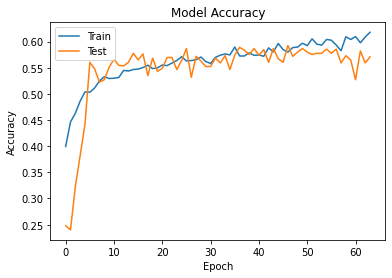

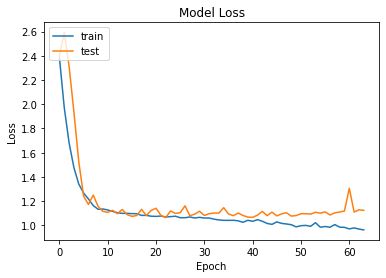

In [49]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [50]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

28/28 [==============================] - 0s 3ms/step - loss: 1.1242 - accuracy: 0.5706
Loss of the model is -  1.1242198944091797
28/28 [==============================] - 0s 3ms/step - loss: 1.1242 - accuracy: 0.5706
Accuracy of the model is -  57.06084966659546 %


In [51]:
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

finaldf = actual.join(predictions)
finaldf[140:160]

,Actual Values,Predicted Values
140,angry,angry
141,neutral,sad
142,sad,neutral
143,sad,neutral
144,angry,angry
145,neutral,neutral
146,neutral,sad
147,neutral,angry
148,sad,sad
149,angry,angry


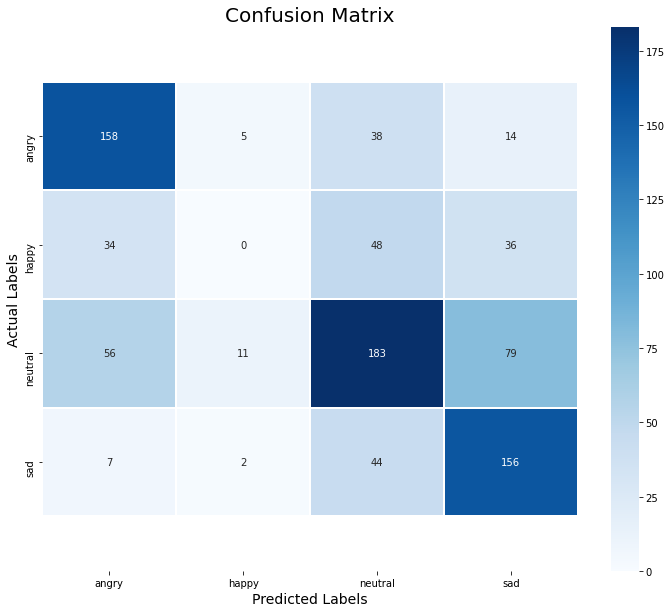

In [52]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()